In [2]:
from dottamine import dotim
import numpy as np
import skimage as sk
# import napari
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import center_of_mass, rotate
import matplotlib.pyplot as plt
import copy


In [3]:
mask = sk.io.imread('domes/70_denoised_mask.tif').astype(np.uint8)
image = sk.io.imread('domes/70_denoised.tif')
image = np.transpose(image[3], axes=(1, 0, 2))
image = np.transpose(image, axes=(2, 1, 0))

In [4]:
print(mask.shape)
print(image.shape)

(858, 550, 858)
(858, 550, 858)


In [5]:
closed_mask = []
for i in mask:
    full = cv2.morphologyEx(i, cv2.MORPH_CLOSE, np.ones((15, 15)))
    closed_mask.append(full)

closed_mask = np.array(closed_mask)
first_nonzero_indices = np.argmax(closed_mask != 0, axis=1)
top_mask = np.zeros_like(closed_mask)
top_mask[np.arange(closed_mask.shape[0])[:, None, None], first_nonzero_indices[:, None, :], np.arange(closed_mask.shape[2])] = 1

    

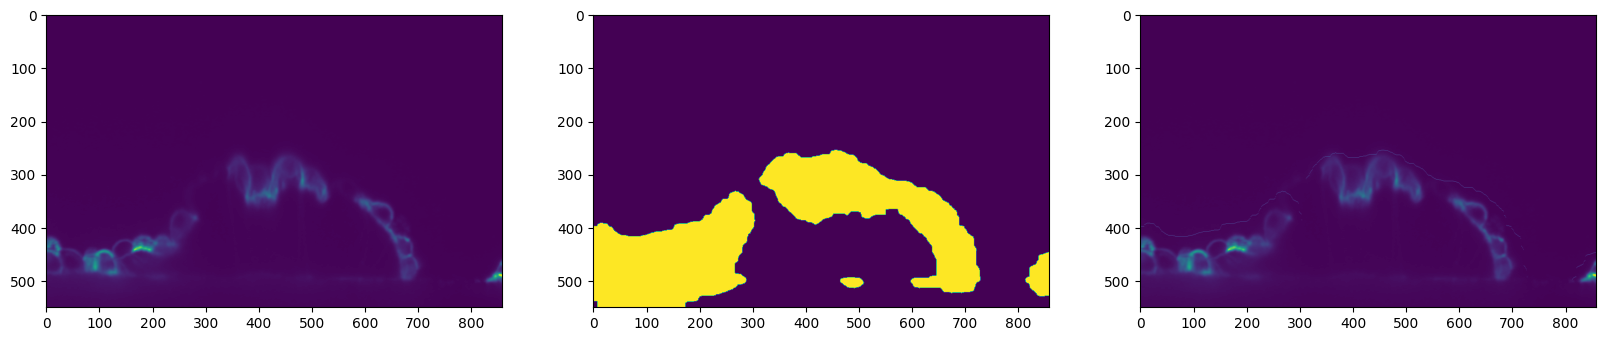

In [6]:
y = 430
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(image[y])
plt.subplot(132)
plt.imshow(closed_mask[y])
plt.subplot(133)
plt.imshow(top_mask[y]*300+image[y])

In [7]:
def smooth_array(arr, window_size):
    kernel = np.ones(window_size) / window_size
    smoothed_arr = np.convolve(arr, kernel, mode='same')
    return smoothed_arr

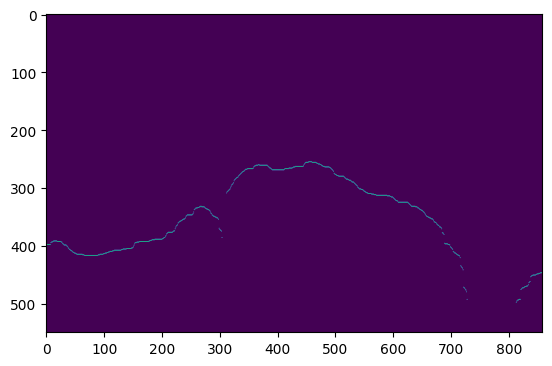

In [8]:
plt.imshow(top_mask[y])

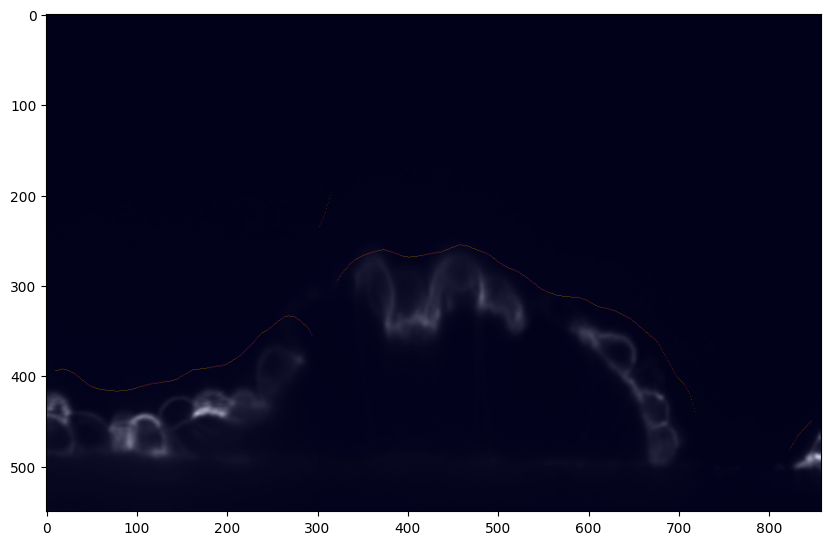

In [9]:
height = []
a = list(range(-5, 5))

for i in range(top_mask[y].shape[1]):
    col = top_mask[y][:, i]
    height.append(np.where(col == 1)[0][0]+0) # Add a value to move the line (+20)

height = np.array(height)
x = np.linspace(0, 1, i+1)

window_size = 20
height = smooth_array(height, window_size)

height_matrix = np.zeros((top_mask[y].shape))

height_smooth = []
height_smooth.append(-1)

for i in range(height_matrix.shape[1]-1):
    if abs(height[i]-height[i+1]) < 10: # Check the absolute difference value! # Should also take into account that two separate points will also appear. (STD?)
        if height[i] == 0 and height[i-1] == 0:
            height_smooth.append(-1)
            continue
        height_matrix[int(height[i])][i] = 1
        height_smooth.append(height[i])

        # # Make the line thicker
        # for kn in a:
        #     height_matrix[int(height[i]+kn)][i] = 1
        # # end


    else:
        height_smooth.append(-1)

plt.figure(figsize=(10,10))
plt.imshow(image[y], cmap='gray')
plt.imshow(height_matrix, alpha=0.2, cmap='plasma')


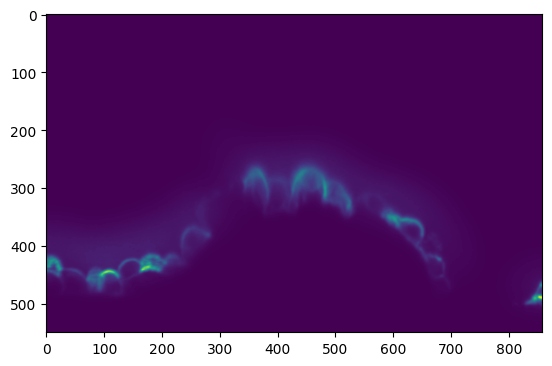

In [10]:
height_mask = cv2.GaussianBlur(height_matrix, (199, 199), 0)*image[y]

plt.imshow(height_mask)
# np.argmax(closed_mask != 0, axis=1)



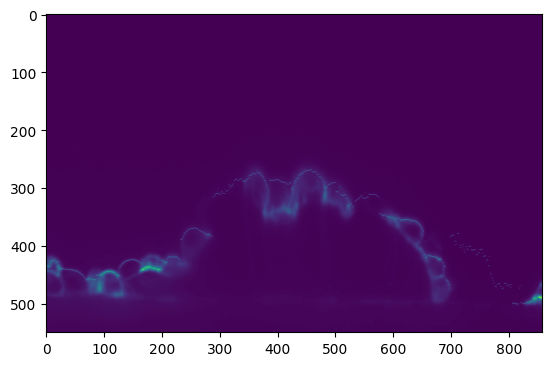

In [11]:
cell_border = []

for i in range(height_mask.shape[1]):
    col = height_mask[:, i]
    cell_border.append(np.argmax(col == max(col)))

cell_top_mask = np.zeros_like(height_mask)
for i in range(cell_top_mask.shape[1]):
    cell_top_mask[cell_border[i], i] = 1


plt.imshow(cell_top_mask*600+image[y])

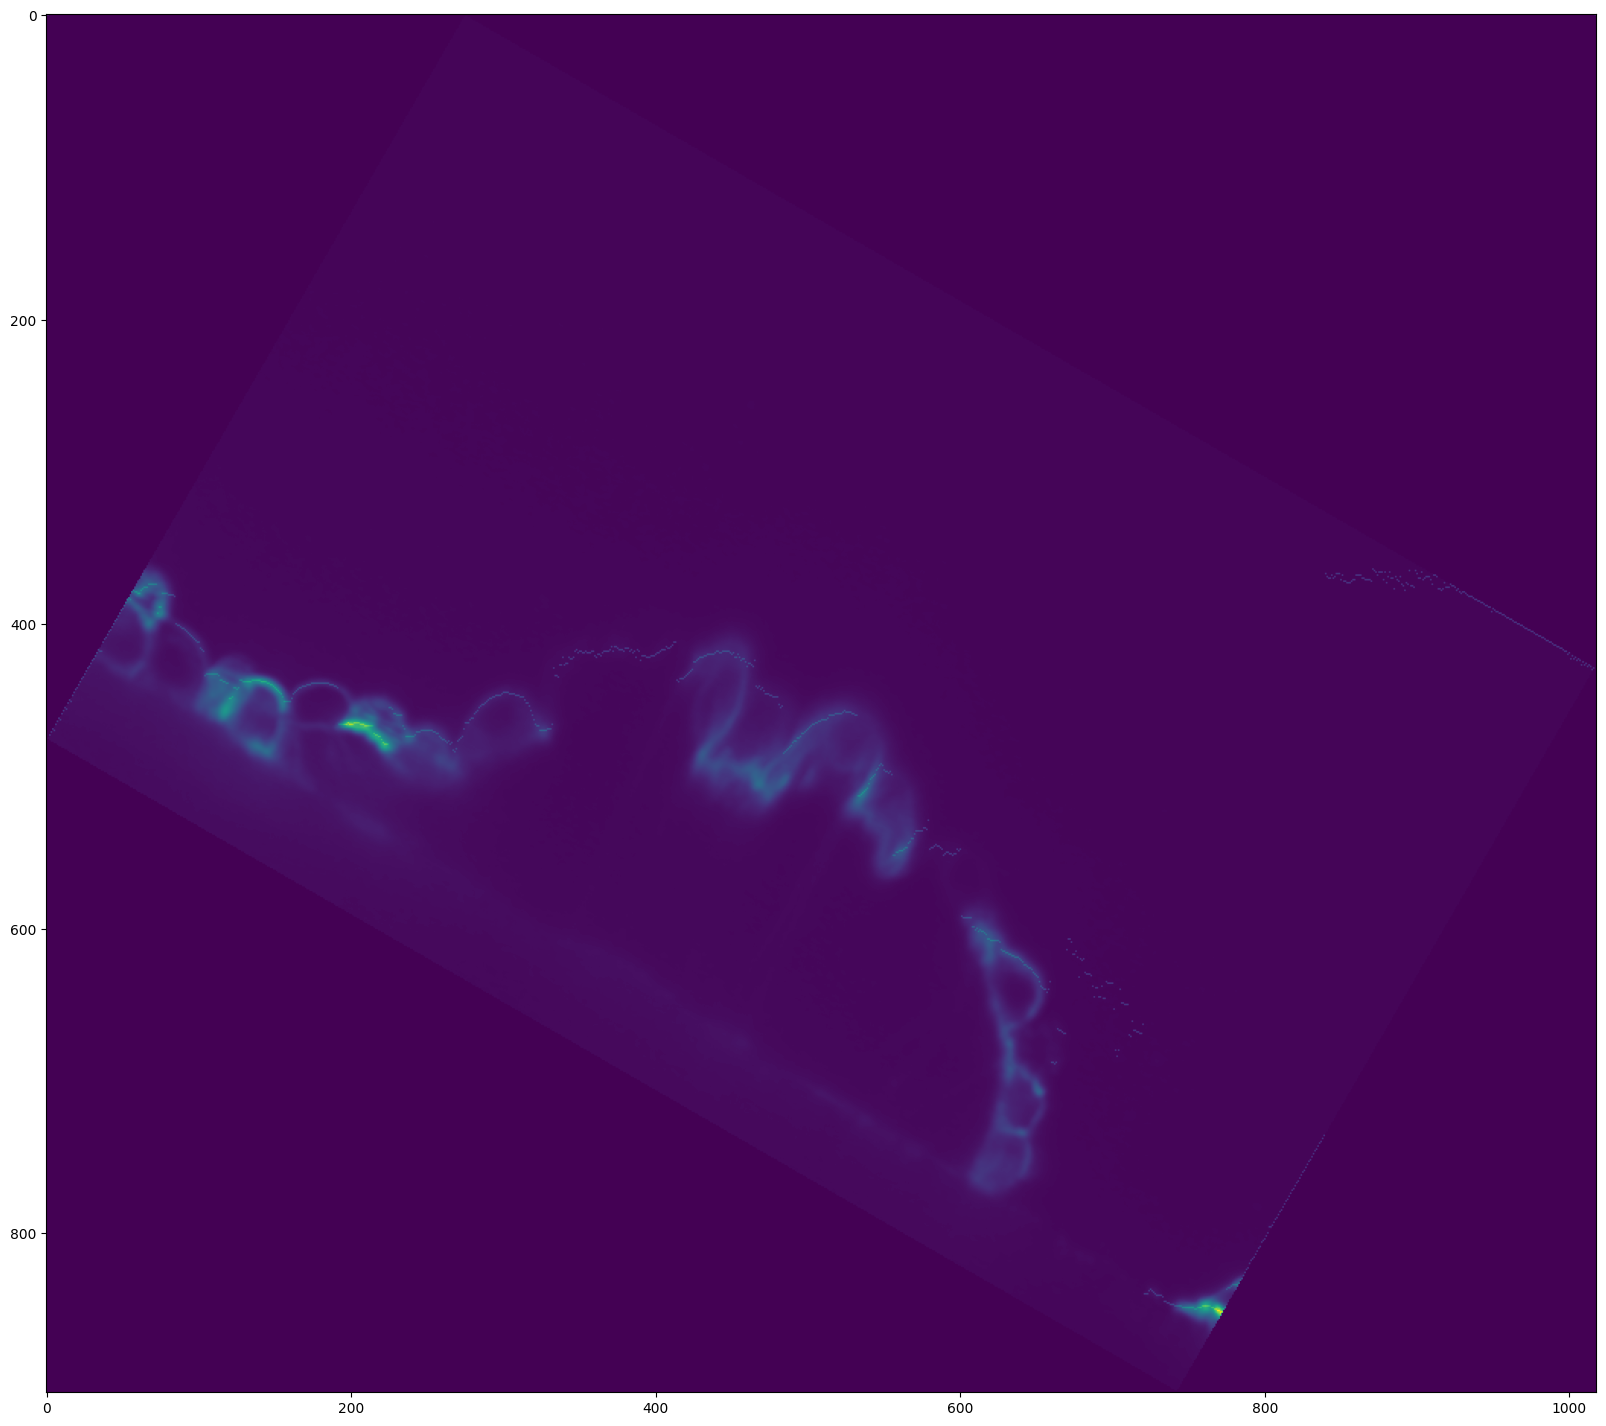

In [12]:
angle = -30
rot_image = rotate(image[y], angle)
rot_height_mask = rotate(height_mask, angle)
cell_top_mask_rot = rotate(height_matrix, angle)

# plt.imshow(rot_image)
# plt.imshow(cell_top_mask_rot, alpha=0.5)


rot_height = []

for i in range(cell_top_mask_rot.shape[1]):
    # print(np.where(cell_top_mask_rot[:,i] == 1))
    rot_height.append(np.where(cell_top_mask_rot[:,i] == 1))

rot_height = np.array(rot_height)


rot_cell_border = []

for i in range(rot_height_mask.shape[1]):
    col = rot_height_mask[:, i]
    rot_cell_border.append(np.argmax(col == max(col)))

cell_top_mask_rot = np.zeros_like(cell_top_mask_rot)
for i in range(rot_height_mask.shape[1]):
    cell_top_mask_rot[rot_cell_border[i], i] = 1

plt.figure(figsize=(20,20))
plt.imshow(cell_top_mask_rot*300+rot_image)

# Multiple angle height map

The idea is to rotate the image a different amount of degrees so we can push down and get the maximum brightness pixels

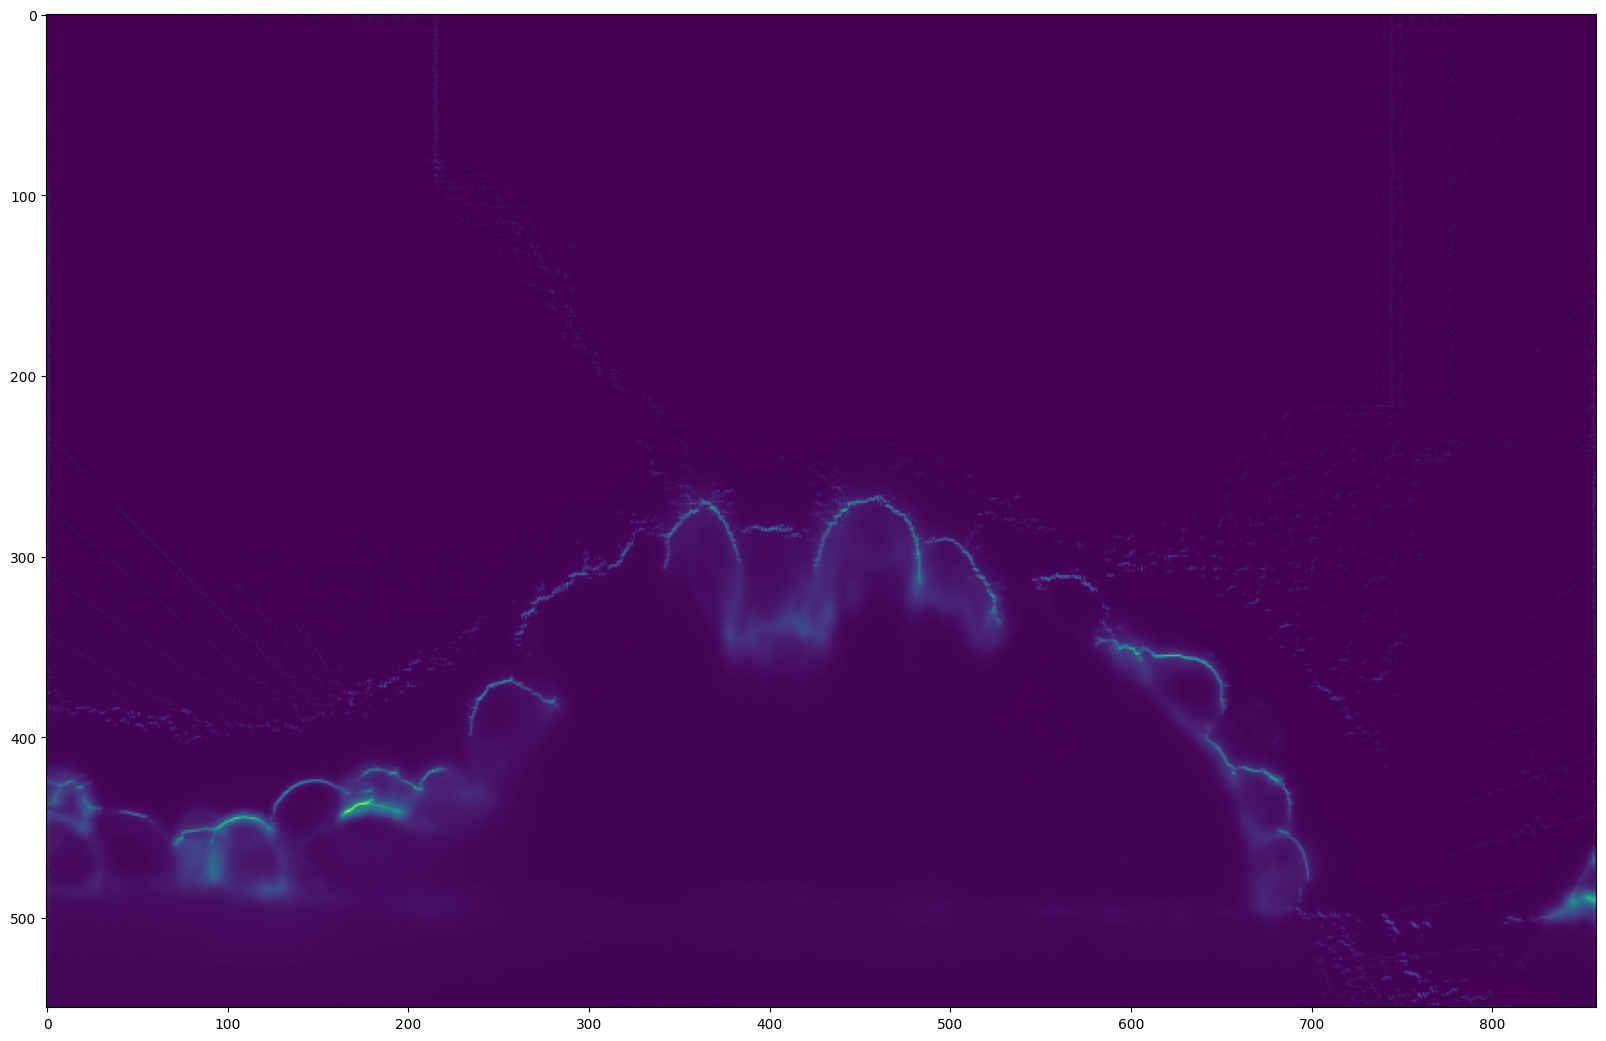

In [34]:
closed_mask = []
for i in mask:
    full = cv2.morphologyEx(i, cv2.MORPH_CLOSE, np.ones((15, 15)))
    closed_mask.append(full)

closed_mask = np.array(closed_mask)
first_nonzero_indices = np.argmax(closed_mask != 0, axis=1)
top_mask = np.zeros_like(closed_mask)
top_mask[np.arange(closed_mask.shape[0])[:, None, None], first_nonzero_indices[:, None, :], np.arange(closed_mask.shape[2])] = 1 # Top mask is a 3D array that contains the top line of the actuall mask

slice_y = 430 # 300, 430

height = [] # Is an array that contains the y values at which the mask starts
for i in range(top_mask[slice_y].shape[1]):
    col = top_mask[slice_y][:, i]
    height.append(np.where(col == 1)[0][0]-20) # Add a value to move the line (+20)
height = np.array(height)

window_size = 20
height = smooth_array(height, window_size)

height_matrix = np.zeros((top_mask[slice_y].shape)) # Is the smoothed line on top of the mask

for i in range(height_matrix.shape[1]-1):
    if abs(height[i]-height[i+1]) < 10: # Check the absolute difference value! # Should also take into account that two separate points will also appear. (STD?)
        if height[i] == 0 and height[i-1] == 0:
            continue
        height_matrix[int(height[i])][i] = 1

height_mask = cv2.GaussianBlur(height_matrix, (199, 199), 0)*image[slice_y]

angles = [i for i in range(-60, 60+1, 5)]

total_cell_mask = np.zeros(shape=(height_mask.shape))

for angle in angles:
    
    rot_height_mask = rotate(height_mask, angle, reshape=False) # Be careful of the reshape=False
    # cell_top_mask_rot = rotate(height_matrix, angle)

    cell_border = []

    for i in range(rot_height_mask.shape[1]):
        col = rot_height_mask[:, i]
        cell_border.append(np.argmax(col == max(col))) # Search for the first mask

    cell_top_mask_rot = np.zeros_like(rot_height_mask)
    for i in range(cell_top_mask.shape[1]):
        cell_top_mask_rot[cell_border[i], i] = 1

    cell_top_mask_rot = rotate(cell_top_mask_rot, -angle, reshape=False)
    cell_top_mask_rot[cell_top_mask_rot < 0] = 0
    total_cell_mask += cell_top_mask_rot



plt.figure(figsize=(20,20))

# plt.imshow(total_cell_mask)
# plt.imshow(image[slice_y], alpha=0.5, cmap='cividis')

plt.imshow(total_cell_mask*100+image[slice_y])


In [36]:
import tifffile as tiff
var = total_cell_mask
var = image[slice_y]
var = var.astype(np.uint16)
tiff.imwrite('../ppujol/dottamine_steps/fall_line430_image.tif',var, imagej=True)

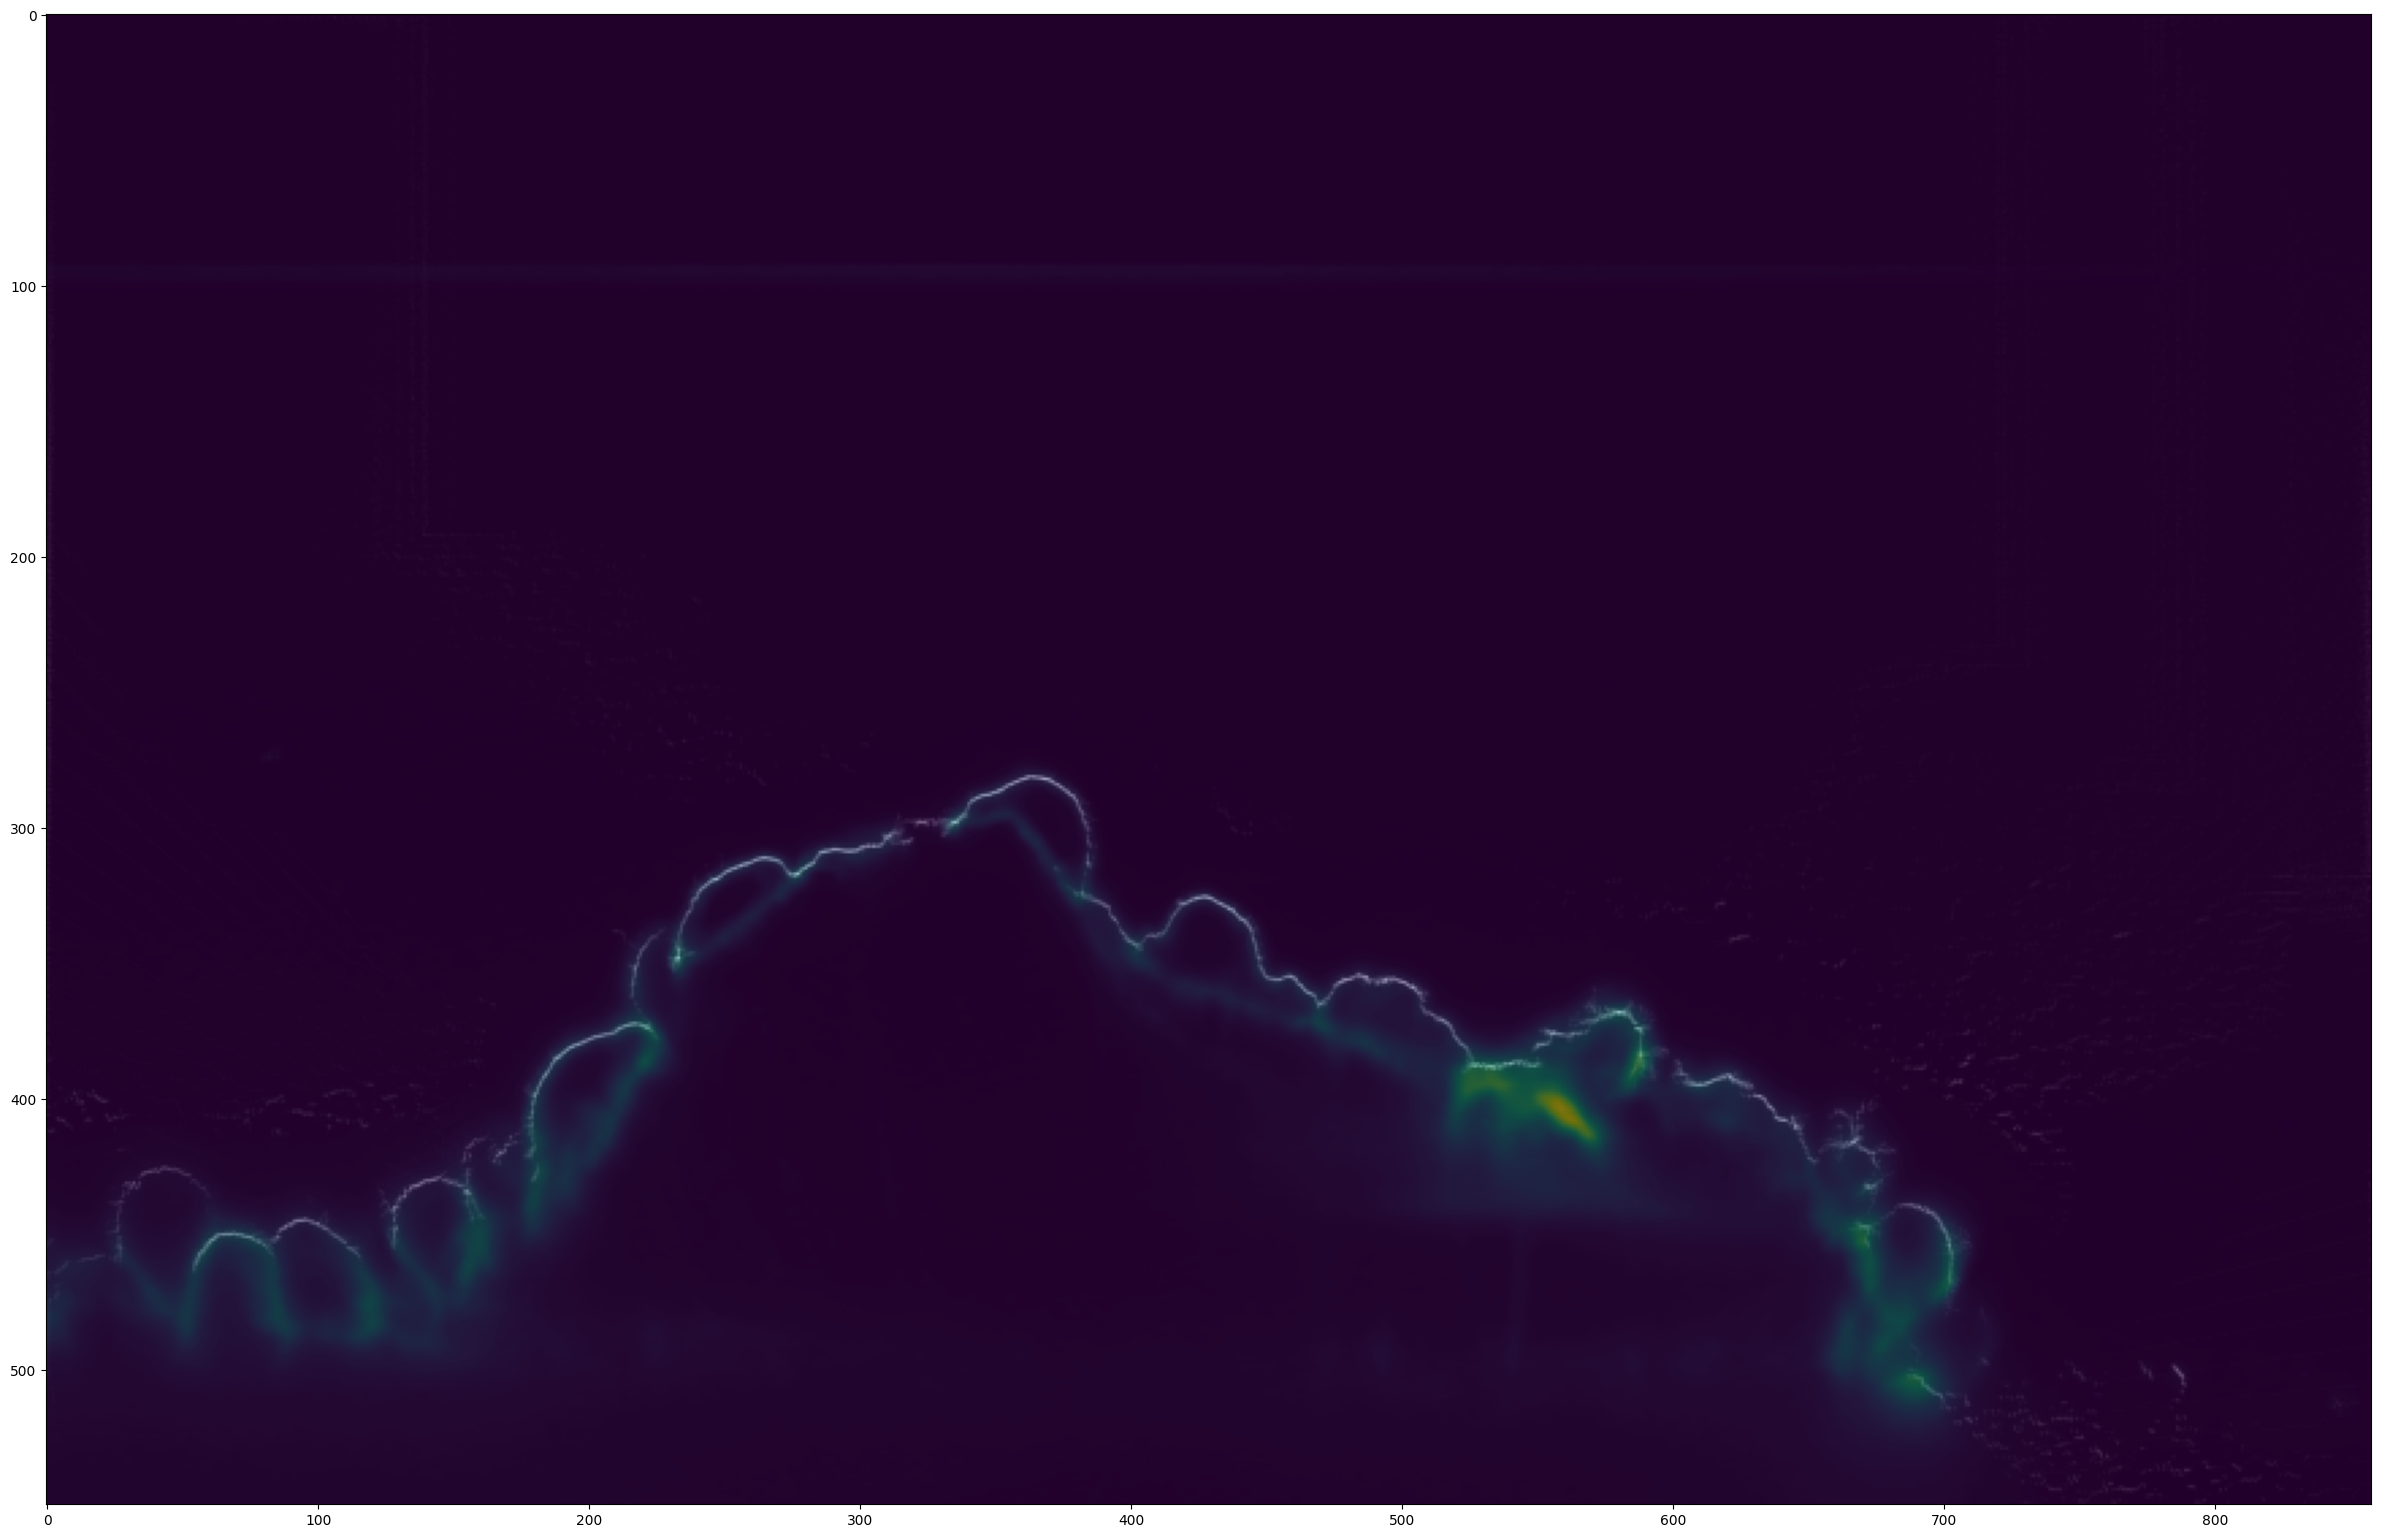

In [465]:
plt.figure(figsize=(30,30))

plt.imshow(total_cell_mask, cmap='gray')
plt.imshow(image[slice_y], alpha=0.5)

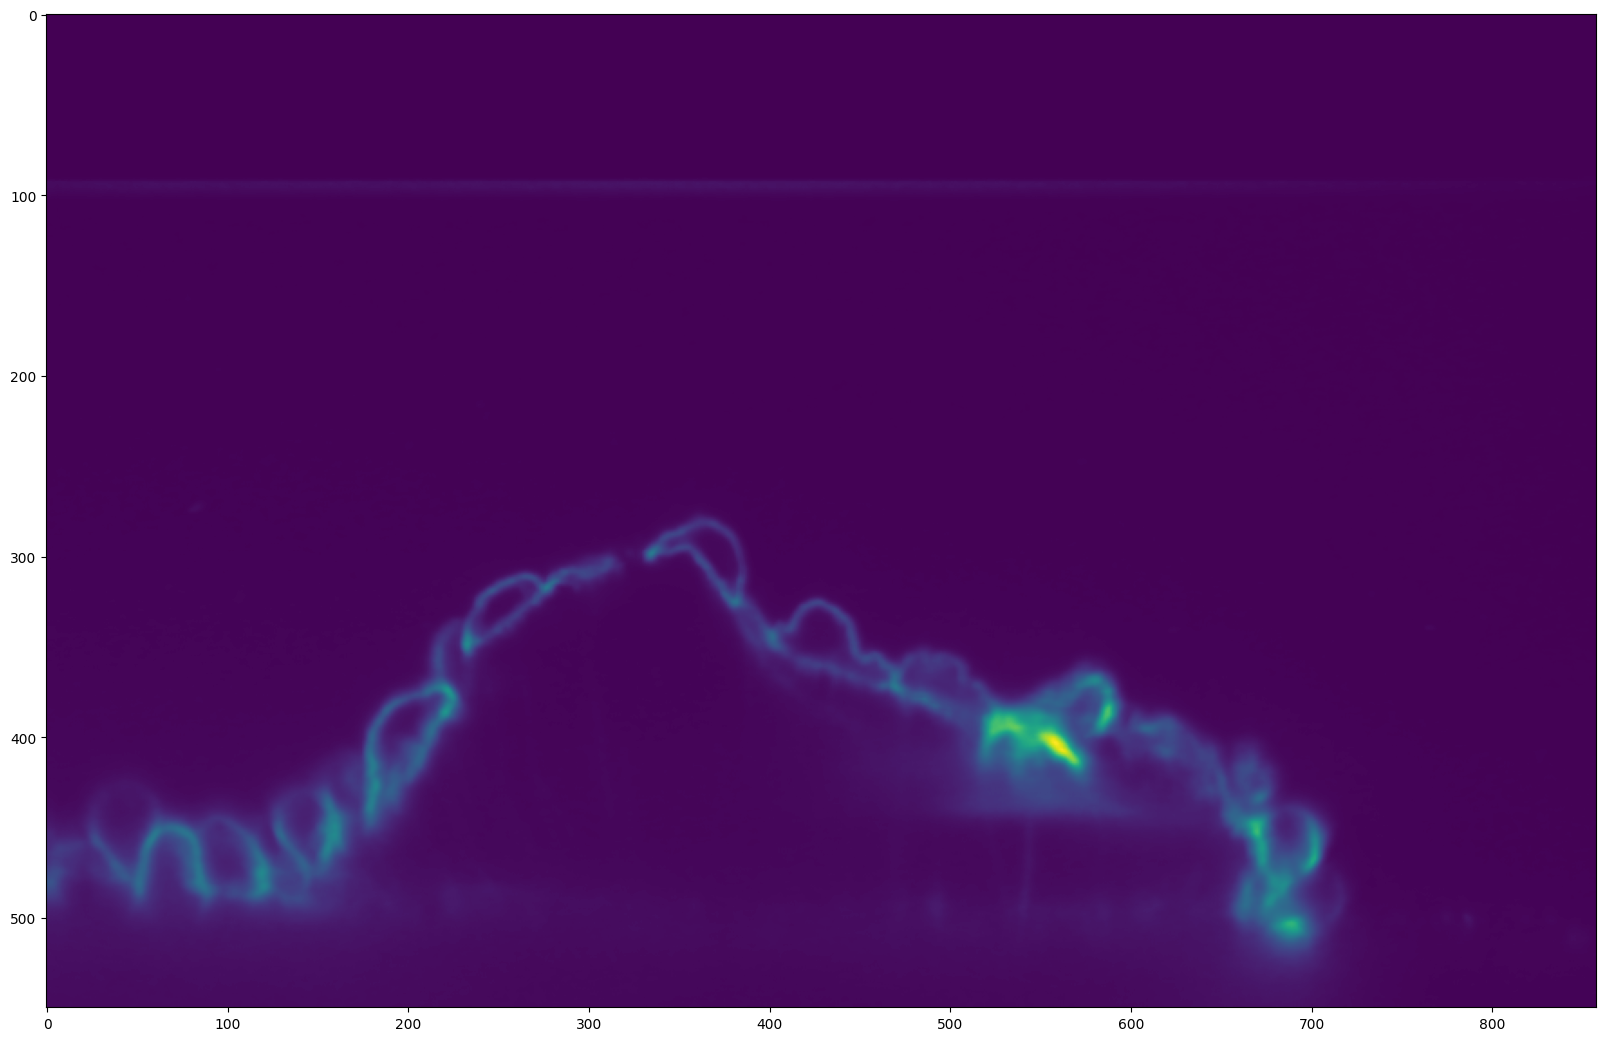

In [464]:
plt.figure(figsize=(20,20))
plt.imshow(image[slice_y])
# plt.imshow(total_cell_mask)

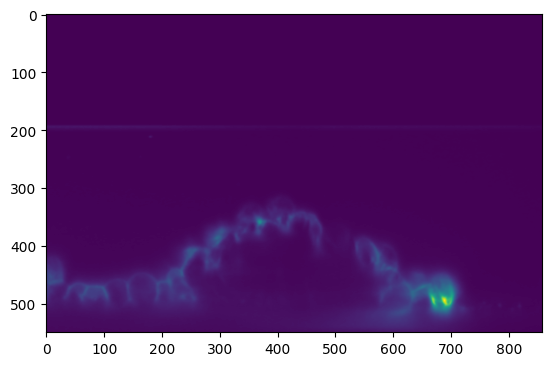

In [447]:
plt.imshow(image[slice_y])

# Get the top of the dome


In [142]:
def bresenham_line(x1, y1, x2, y2):
    points = []

    dx = abs(x2 - x1)
    dy = abs(y2 - y1)

    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1

    error = dx - dy

    x, y = x1, y1

    while True:
        points.append((x, y))

        if x == x2 and y == y2:
            break

        e2 = 2 * error

        if e2 > -dy:
            error -= dy
            x += sx

        if e2 < dx:
            error += dx
            y += sy

    return points

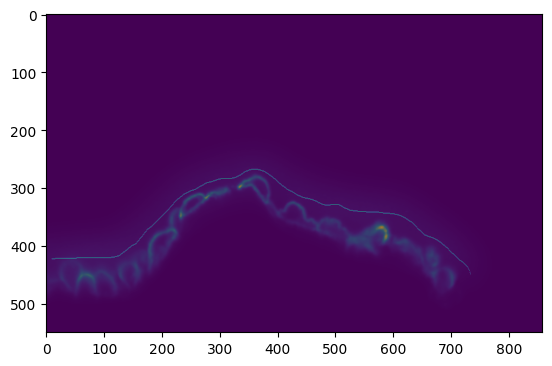

In [264]:
# Find the normal vector at each point of the curve so we can find brightest intensities.

height_smooth = [int(i) for i in height_smooth]

x_vector = np.linspace(1, len(height_smooth), len(height_smooth))
derivative = np.gradient(height_smooth) # If derivative is 0, that means the normal is completely vertical.                         #### Tangent
# So the m of the perpendicular vector to the derivative must be 1/derivative. 
m_normals = ['inf' if i == 0 else -1/i for i in derivative]                                                                         #### M of Normal vector
n_normals = [] # This vector contains the n if the normal of the derivative is not an 'inf' or the n if the normal is a line.       #### N of Normal vector

for m_normal, y_smooth, x_value in zip(m_normals, height_smooth, x_vector):
    if m_normal == 'inf':
        n_normals.append(x_value)
    else:
        n_normals.append(y_smooth-m_normal*x_value)

# m_normals, n_normals = np.array(m_normals), np.array(n_normals)

plt.imshow(height_mask)
plt.imshow(height_matrix, alpha=0.5)

In [332]:
r = 100

intensities = np.zeros((200,1000))

x = 0

for i in x_vector:
    col = int(i-1)
    x1 = x_vector[col]
    y1 = height_smooth[col]
    m = m_normals[col]
    n = n_normals[col]
    t = derivative[col]

    # print(x1, y1, t, m)

    if m != 'inf' and y1 != -1:
        x2 = x1 + r/np.sqrt(1+m**2)
        y2 = x2 * m + n

        # print(x1, y1, x2, y2, t, m)

        # print(np.linalg.norm(np.array([x1,y1])-np.array([x2,y2])))


    if m == 'inf':
        x2 = x1
        y2 = y1 - r

    y = 0

    for b in bresenham_line(int(x1), int(y1), int(x2), int(y2)):
        if b[0] < height_mask.shape[0] and b[1] < height_mask.shape[1]:
            intensities[y,x] = height_mask[b[1], b[0]]

        y+=1

    x+=1

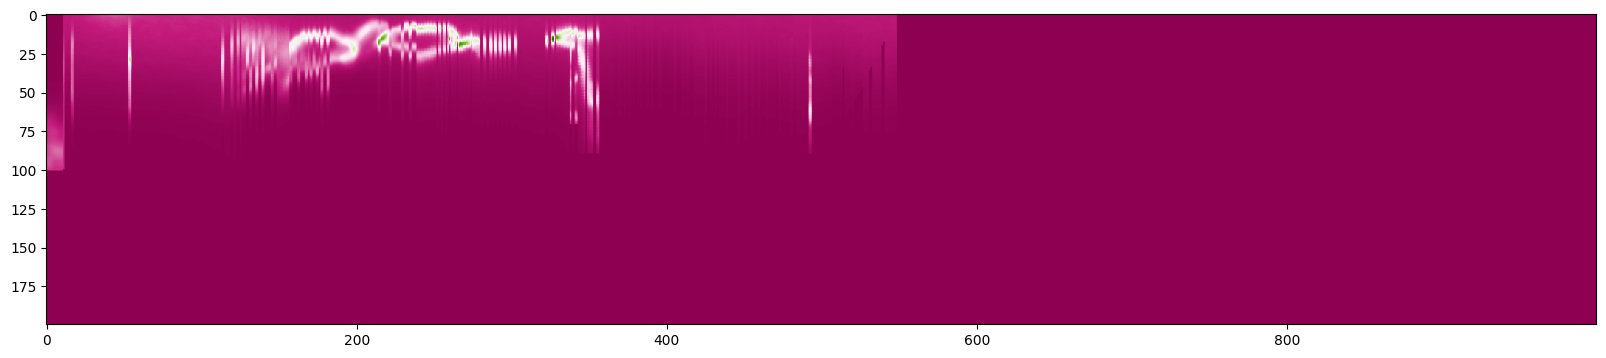

In [333]:
plt.figure(figsize=(20,20))
plt.imshow(intensities, cmap='PiYG')

# Height mask

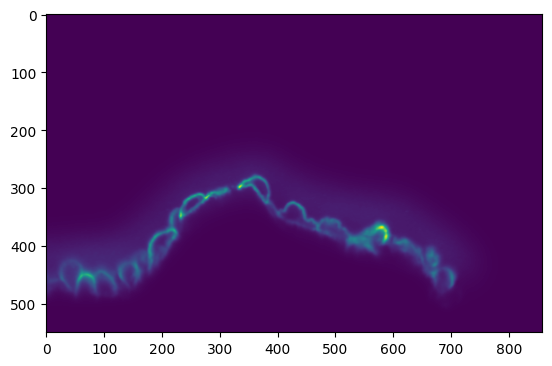

In [99]:
plt.imshow(height_mask)

454 5.642139901839552


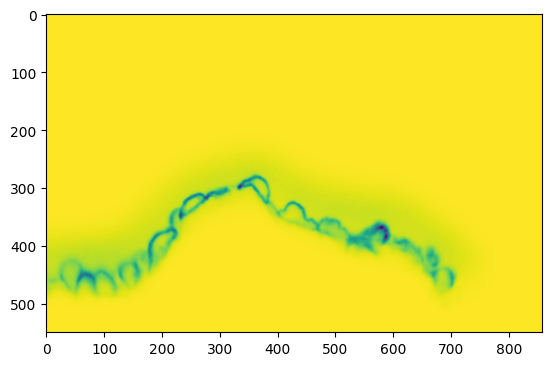

In [118]:
inverse_height_mask = height_mask.max()-height_mask
# [0,:] per anar horitzontal
# [:,0] per anar vertical

plt.imshow(inverse_height_mask)
# print(np.argmin(inverse_height_mask[:,0]), min(inverse_height_mask[:,0]))

ap = 1 # around penalization. Some value must be computed in order to know how much we should increase the intensity.

init_point, init_value = np.argmin(inverse_height_mask[:,0]), min(inverse_height_mask[:,0])

def diagonal():
    return

def straight():
    return

for i in range(10):
    y, x = init_point, 0



# Seam Scarving

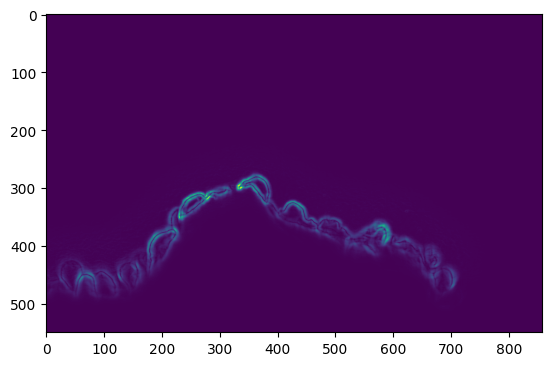

In [98]:
# Seam Carving
from scipy.ndimage import convolve

def calc_energy(img):
    filter_du = np.array([
        [1.0, 2.0, 1.0],
        [0.0, 0.0, 0.0],
        [-1.0, -2.0, -1.0],
    ])

    filter_dv = np.array([
        [1.0, 0.0, -1.0],
        [2.0, 0.0, -2.0],
        [1.0, 0.0, -1.0],
    ])

    img = img.astype('float32')
    energy_map = np.absolute(convolve(img, filter_du)) + np.absolute(convolve(img, filter_dv))

    return energy_map

energy = calc_energy(height_mask)

plt.imshow(energy)


def minimum_seam(img):
    r, c = img.shape
    energy_map = calc_energy(img)

    M = energy_map.copy()
    backtrack = np.zeros_like(M)

    for i in range(1, r):
        for j in range(0, c):
            # Handle the left edge of the image, to ensure we don't index -1
            if j == 0:
                idx = np.argmin(M[i - 1, j:j + 2])
                backtrack[i, j] = idx + j
                min_energy = M[i - 1, idx + j]
            else:
                idx = np.argmin(M[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]

            M[i, j] += min_energy

    return M, backtrack


M, backtrack = minimum_seam(height_mask)

# plt.imshow(M)


def carve_column(img):
    r, c = img.shape

    M, backtrack = minimum_seam(img)

    # Create a (r, c) matrix filled with the value True
    # We'll be removing all pixels from the image which
    # have False later
    mask = np.ones((r, c))

    # Find the position of the smallest element in the
    # last row of M
    j = np.argmin(M[-1])

    for i in reversed(range(r)):
        # Mark the pixels for deletion

        i = int(i)
        j = int(j)

        mask[i, j] = 0
        j = backtrack[i, j]

    # Since the image has 3 channels, we convert our
    # mask to 3D
    

    # Delete all the pixels marked False in the mask,
    # and resize it to the new image dimensions

    plt.imshow(mask)

    #img = img[mask].reshape((r, c - 1))

    return img

# plt.imshow(carve_column(height_mask))
# 
# carve_column(np.rot90(np.argmax(height_mask)-height_mask));

# Get 3D top 

In [12]:
mask = sk.io.imread('domes/70_denoised_mask.tif').astype(np.uint8)
image = sk.io.imread('domes/70_denoised.tif')
image = np.transpose(image[3], axes=(1, 0, 2))
image = np.transpose(image, axes=(2, 1, 0))

closed_mask = []
for i in mask:
    full = cv2.morphologyEx(i, cv2.MORPH_CLOSE, np.ones((15, 15)))
    closed_mask.append(full)

closed_mask = np.array(closed_mask)
first_nonzero_indices = np.argmax(closed_mask != 0, axis=1)
top_mask = np.zeros_like(closed_mask)
top_mask[np.arange(closed_mask.shape[0])[:, None, None], first_nonzero_indices[:, None, :], np.arange(closed_mask.shape[2])] = 1

def smooth_array(arr, window_size):
    kernel = np.ones(window_size) / window_size
    smoothed_arr = np.convolve(arr, kernel, mode='same')
    return smoothed_arr

clean_mask = []

c = 0

for n in range(image.shape[0]):

    print(c,end='\r')
    c += 1

    height = []

    for i in range(top_mask[n].shape[1]):
        col = top_mask[n][:, i]
        height.append(np.where(col == 1)[0][0]+20) # Add a value to move the line

    height = np.array(height)
    x = np.linspace(0, 1, i+1)

    window_size = 20
    height = smooth_array(height, window_size)

    height_matrix = np.zeros((top_mask[n].shape))

    height_smooth = []
    height_smooth.append(-1)

    for i in range(height_matrix.shape[1]-1):
        if abs(height[i]-height[i+1]) < 10: # Check the absolute difference value!
            if height[i] == 0 and height[i-1] == 0:
                height_smooth.append(-1)
                continue
            height_matrix[int(height[i])][i] = 1
            height_smooth.append(height[i])
        else:
            height_smooth.append(-1000)    


    clean_mask.append(cv2.GaussianBlur(height_matrix, (199, 199), 0)*image[n])

clean_mask = np.array(clean_mask)


In [14]:
import tifffile as tiff
tiff.imsave('domes/clean70_dome.tif', clean_mask.astype(np.float32))

/tmp/ipykernel_5392/189814410.py:2: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave('domes/clean70_dome.tif', clean_mask.astype(np.float32))


: 